<a href="https://colab.research.google.com/github/leemaHmaid/Cassava-Classification-Competition/blob/main/notebook6f6e719192.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'ammi-2024-computer-vision:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F77142%2F8400328%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240731%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240731T002738Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D86112ecd4658a342bfaa7b3685d20118eb1747eb5639e35d6401bb35f621ce7bfaadd04f27708a36bb9167c41bf3389de4e4c9c1389124be22d141e05b9e24dc53258f08f8417e143ba8100b8981a917139803306d3646ca8dd14e49d0dc5902c40ef748c135377e3cdcd038648c9ef1483365a9e4fd0556e96b39abae8c6f303fbd20f50040caeda5f6901ccce19add03799b207433716f665e548a2d270af11acd2782e89b6047527b2e6444141b788b7df3e602a4972a6cdeb2746b4df9c497ea1bf696f729a108ea7bf6d05e2e9b61b55cb5b067a9bf91a7c4d8fcc8d0a1d3f57ea4b0eb05a075d8afd02907a2185dbb0bd9d06b0ecfeec9e00c729b5263'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
#Imports
import os
import sys
import glob
import torch
import torchvision
import pandas as pd

import numpy    as np
import datetime as dt
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot   as plt

from PIL               import Image
from torch.utils.data  import Dataset
from torch.autograd    import Variable
from torch.optim       import lr_scheduler
import timm
from torch.utils.tensorboard import SummaryWriter

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from contextlib import contextmanager
from collections import defaultdict, Counter
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import KFold

import scipy as sp

from torch.utils.data  import Dataset, DataLoader,Subset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision       import transforms, datasets, models
from torchvision.models import resnext50_32x4d,resnext101_64x4d,ResNeXt101_64X4D_Weights,ResNeXt50_32X4D_Weights
from os                import listdir, makedirs, getcwd, remove
from os.path           import isfile, join, abspath, exists, isdir, expanduser

from torchvision.datasets import DatasetFolder
from sklearn.model_selection import StratifiedKFold


%matplotlib inline

2024-05-19 20:25:23.061588: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-19 20:25:23.061714: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-19 20:25:23.197869: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
!pip install --upgrade certifi

import ssl
import urllib
from urllib.request import urlopen

ssl._create_default_https_context = ssl._create_unverified_context

In [ ]:
# pip install --upgrade certifi


In [ ]:
data_path = "/kaggle/input/ammi-2024-computer-vision/"
train_path = join(data_path, "train/train")
test_path = join(data_path,"test/test")
extraimage_path = join(data_path, "extraimages/extraimages")

In [ ]:
# Transformations for both the training and testing data
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transforms = A.Compose([
    A.RandomResizedCrop(width= 448, height= 448),
    A.Rotate(limit=30, p=0.5),
    A.Transpose(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
#     A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    A.Normalize(mean=mean, std=std),
    ToTensorV2()
])

test_transforms = A.Compose([
    A.Resize(width=500, height=500),
    A.CenterCrop(width=448, height=448),
    A.Normalize(mean=mean, std=std),
    ToTensorV2()
])



In [ ]:
class CFG:
    debug=False
    num_workers=8
    model_name= 'se_resnext101_32x8d'

    size=512
    batch_size=16
    seed=42
    target_size=5
    target_col='label'
    n_fold=5
    trn_fold=[0, 1, 2, 3, 4]
    inference=True

In [ ]:
class CassavaDataset(Dataset):
    def __init__(self, path, transform=None):
        self.classes = os.listdir(path)
        self.path = [f"{path}/{className}" for className in self.classes]
        self.file_list = [glob.glob(f"{x}/*") for x in self.path]
        self.transform = transform
        self.classes_Dict = {}
        self.classes_count = {}

        files = []
        for i, className in enumerate(self.classes):
            for fileName in self.file_list[i]:
                self.classes_Dict[i] = className
                files.append([i, className, fileName])
        self.file_list = files
        files = None

        classes_in_file = []
        for file in self.file_list:
            classes_in_file.append(file[1])
        class_counts = {}
        for name in classes_in_file:
            if name in class_counts:
                class_counts[name] += 1
            else:
                class_counts[name] = 1
        self.classes_count = class_counts
    def get_image_filename(self, idx):
        file_path = self.file_list[idx][2]
        file_name = file_path.split("/")[-1]
        return file_name


    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        fileName = self.file_list[idx][2]
        classCategory = self.file_list[idx][0]
        im = Image.open(fileName)
        im = np.array(im)
        if self.transform:
            augmented= self.transform(image=im)
            im = augmented['image']

        return im, classCategory

In [ ]:
train_data = CassavaDataset(train_path, transform=train_transforms)
test_data = CassavaDataset(test_path, transform=test_transforms)

In [ ]:
# Define the K-fold Cross Validator
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
BATCH_SIZE = 2
# K-fold Cross Validation model evaluation
data_loaders = []
for fold, (train_ids, val_ids) in enumerate(kfold.split(train_data)):
    train_dataset = Subset(train_data, train_ids)
    val_dataset = Subset(train_data, val_ids)


    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                                                 drop_last=True)
    valid_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                                                 drop_last=True)

    data_loaders.append((train_loader, valid_loader))

In [ ]:
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(train_data)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]


In [ ]:
# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=4)

In [ ]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

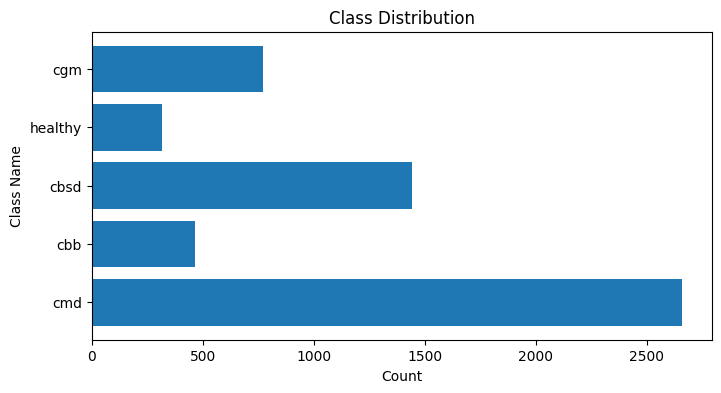

In [ ]:
plt.figure(figsize=(8, 4))  # Set the figure size
unique_classes = list(train_data.classes_count.keys())
unique_classes_count= list(train_data.classes_count.values())
plt.barh(unique_classes,unique_classes_count)

plt.xlabel("Count")
plt.ylabel("Class Name")
plt.title("Class Distribution")

plt.show()


In [ ]:
!pip install --upgrade certifi

import ssl
import urllib
from urllib.request import urlopen

ssl._create_default_https_context = ssl._create_unverified_context

In [ ]:
!pip install pretrainedmodels >/dev/null 2>&1
import pretrainedmodels

In [ ]:
def se_resnext101_32x4d(pretrained=True):
    pretrained = 'imagenet' if pretrained else None
    model = pretrainedmodels.se_resnext101_32x4d(pretrained=pretrained)
    return model

In [ ]:
class SEResnext101(nn.Module):
    def __init__(self, model, num_classes=1000):
        super().__init__()
        self.backbone = model
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(2048, 5)
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
    def forward(self, x):
        x = self.backbone.layer0(x)
        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)
        x = self.avg_pool(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x




In [ ]:
def get_model(model_name = 'se_resnext101_32x4d'):

    if model_name == 'se_resnext101_32x4d':
        base_model = se_resnext101_32x4d(pretrained=True)
        model_ft = SEResnext101(base_model, 5)

    elif model_name == 'se_resnext50_32x4d':
        model_ft = se_resnext50_32x4d(pretrained=False)
        model_ft.avg_pool = torch.nn.AdaptiveAvgPool2d(1)

        num_ftrs = model_ft.last_linear.in_features
        model_ft.last_linear = torch.nn.Linear(num_ftrs, 5)

    elif model_name == 'resnet50':
        base_model = models.resnet50(pretrained=True)
        model_ft = ResNet50(base_model, 5)

        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, 5)

    model_ft = model_ft.to(device)
    return model_ft



In [ ]:
model_ft = get_model(model_name = 'se_resnext101_32x4d')


Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/se_resnext101_32x4d-3b2fe3d8.pth" to /root/.cache/torch/hub/checkpoints/se_resnext101_32x4d-3b2fe3d8.pth
100%|██████████| 187M/187M [09:11<00:00, 356kB/s]    


In [ ]:
criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model_ft .parameters(), lr=1e-3)
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=5, min_lr=0.0001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

In [ ]:
writer = SummaryWriter()

In [ ]:
def predict(model, data_loader):
    model.eval()
    preds = []
    for images, _ in data_loader:
        # Forward pass.
        output = model(images.to(device))
        # Get the label corresponding to the highest predicted probability.
        pred = output.argmax(dim=1, keepdim=True)
        for p in pred:
            pred_class = train_data.classes_Dict[p.item()]
            preds.append(pred_class)
    return preds

In [ ]:
 def train(model,data_loader, optimizer, scheduler, num_epochs=5):
    """Simple training loop for a PyTorch model."""

    # Make sure model is in training mode.
    model.train()

    # Move model to the device (CPU or GPU).
    model.to(device)

    # Exponential moving average of the loss.
    train_ema_loss = None
    train_losses = []
    valid_losses = []
    best_accuracy = 0.0  # Variable to track the best accuracy
    print('----- Training Loop -----')

    # Loop over epochs.
    for epoch in range(num_epochs):
        epoch_val_acc = []

        # Loop over data.
        for fold, (train_loader, valid_loader) in enumerate(data_loader):
            correct = 0

            for _, (features, target) in enumerate(train_loader):
                # Forward pass.
                output = model(features.to(device))
                train_loss = criterion(output.to(device), target.to(device))

                # Backward pass.
                optimizer.zero_grad()
                train_loss.backward()
                optimizer.step()

                if train_ema_loss is None:
                    train_ema_loss = train_loss.item()
                else:
                    train_ema_loss += (train_loss.item() - train_ema_loss) * 0.01

            train_losses.append(train_ema_loss)

            # Evaluate on the validation set
            model.eval()
            total_valid_loss = 0
            valid_ema_loss = None
            with torch.no_grad():
                for _, (features, target) in enumerate(valid_loader):
                    output = model(features.to(device))
                    valid_loss = criterion(output.to(device), target.to(device))
                    pred = output.argmax(dim=1, keepdim=True)
                    correct += pred.cpu().eq(target.view_as(pred)).sum().item()

                    if valid_ema_loss is None:
                        valid_ema_loss = valid_loss.item()
                    else:
                        valid_ema_loss += (valid_loss.item() - valid_ema_loss) * 0.01

                valid_losses.append(valid_ema_loss)
                scheduler.step(valid_ema_loss)

                # Calculate validation accuracy
                validation_accuracy = correct / len(valid_loader.dataset)
                epoch_val_acc.append(validation_accuracy)

                # Save the model if it has the best accuracy so far
                if validation_accuracy > best_accuracy:
                    best_accuracy = validation_accuracy
                    torch.save(model.state_dict(), 'best_model.ckpt')

            # Print progress at the end of the epoch.
            print(f'Epoch: {epoch}, Fold: {fold}, Train Loss: {train_ema_loss:.6f}, Valid Loss: {valid_ema_loss:.6f}')
            print(f'Validation accuracy: {correct} / {len(valid_loader.dataset)} ({validation_accuracy:.2%})')
            model.train()

            iteration = epoch * len(data_loader) + fold
            writer.add_scalar("Loss/Train", train_ema_loss, iteration)
            writer.add_scalar("Loss/Validation", valid_ema_loss, iteration)

        print(f'Epoch accuracy: {np.mean(epoch_val_acc)}')

    # Close the TensorBoard writer
    writer.close()

    return train_losses, valid_losses

In [ ]:
def test(model, data_loader):
    """Measures the accuracy of a model on a data set."""
    # Make sure the model is in evaluation mode.
    model.eval()
    correct = 0
    print('----- Model Evaluation -----')
    # We do not need to maintain intermediate activations while testing.
    with torch.no_grad():

        # Loop over test data.
        for features, target in data_loader:

            # Forward pass.
            output = model(features.to(device))

            # Get the label corresponding to the highest predicted probability.
            pred = output.argmax(dim=1, keepdim=True)


            # Count number of correct predictions.
            correct += pred.cpu().eq(target.view_as(pred)).sum().item()

    # Print test accuracy.
    percent = 100. * correct / len(data_loader.dataset)
    print(f'Test accuracy: {correct} / {len(data_loader.dataset)} ({percent:.0f}%)')
    torch.save(model.state_dict(), 'model.ckpt')
    return percent

In [ ]:
def predict(model, data_loader):
    model.eval()
    preds = []
    for images, _ in data_loader:
        # Forward pass.
        output = model(images.to(device))
        # Get the label corresponding to the highest predicted probability.
        pred = output.argmax(dim=1, keepdim=True)
        for p in pred:
            pred_class = train_data.classes_Dict[p.item()]
            preds.append(pred_class)
    return preds

In [ ]:
def generate_submission_file(predictions):
    mapped_preds = []
    for idx in range(len(test_data)):
        mapped_preds.append({'Category': predictions[idx], 'Id': test_data.get_image_filename(idx)})
    pd.DataFrame(mapped_preds).to_csv("sample_submission_file_new.csv", index=False)

In [ ]:
# num_epochs = 10
# num_folds = 5
# batch_size = 16
# dataset = CassavaDataset(train_path, transform=train_transforms)

# # Initialize StratifiedKFold
# skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# fold_accuracies = []

# for fold, (train_idx, val_idx) in enumerate(skf.split(dataset.file_list, [label for _, label, _ in dataset.file_list])):
#     print(f'Fold {fold+1}/{num_folds}')
#     train_sampler = SubsetRandomSampler(train_idx)
#     val_sampler = SubsetRandomSampler(val_idx)

#     train_loader_fold = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
#     val_loader_fold = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)

#     # Initialize a new model for each fold
#     model = CustomResNext(model_name='resnext50_32x4d', pretrained = False)

#     optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

#     # Train the model
#     train(model, criterion, train_loader_fold, optimizer, num_epochs)

#     # Validate the model
#     accuracy = test(model, val_loader_fold)
#     fold_accuracies.append(accuracy)

# # Print the average performance across folds
# print(f'Average Cross-Validation Accuracy: {np.mean(fold_accuracies):.2f}%')

# # Test the final model on the test set
# final_accuracy = test(model, DataLoader(test_data, batch_size=batch_size))
# # predictions = predict(model, test_loader)
# # Make submission here
# # generate_submission_file(predictions)
# print(f'Final Test Accuracy: {final_accuracy:.2f}%')


In [ ]:
print(f'Final Test Accuracy: {final_accuracy:.2f}%')

In [ ]:
predictions = predict(model_ft, test_loader)
# Make submission here
generate_submission_file(predictions)

In [ ]:
num_epochs = 5
train(model_ft,data_loaders, optimizer, scheduler, num_epochs=5)
# test(model, valid_loader)

----- Training Loop -----
Epoch: 0, Fold: 0, Train Loss: 0.873290, Valid Loss: 0.666046
Validation accuracy: 881 / 1132 (77.83%)
Epoch: 0, Fold: 1, Train Loss: 0.683423, Valid Loss: 0.493190
Validation accuracy: 867 / 1131 (76.66%)
Epoch: 0, Fold: 2, Train Loss: 0.653806, Valid Loss: 0.293903
Validation accuracy: 940 / 1131 (83.11%)
Epoch: 0, Fold: 3, Train Loss: 0.595937, Valid Loss: 0.293209
Validation accuracy: 936 / 1131 (82.76%)
Epoch: 0, Fold: 4, Train Loss: 0.550470, Valid Loss: 0.586179
Validation accuracy: 926 / 1131 (81.87%)
Epoch accuracy: 0.8044600762950951
Epoch: 1, Fold: 0, Train Loss: 0.533657, Valid Loss: 0.334607
Validation accuracy: 966 / 1132 (85.34%)
Epoch 00007: reducing learning rate of group 0 to 1.0000e-04.
Epoch: 1, Fold: 1, Train Loss: 0.554320, Valid Loss: 0.334514
Validation accuracy: 940 / 1131 (83.11%)
Epoch: 1, Fold: 2, Train Loss: 0.470838, Valid Loss: 0.330421
Validation accuracy: 1002 / 1131 (88.59%)
Epoch: 1, Fold: 3, Train Loss: 0.414964, Valid Loss:

([0.8732899131224321,
  0.6834234303726101,
  0.6538064266373915,
  0.595937305613116,
  0.5504699286479201,
  0.5336566652464545,
  0.5543201468718626,
  0.4708383147904551,
  0.4149642012516712,
  0.3956454053520135,
  0.39537387635994176,
  0.3689130385817739,
  0.37015011991553654,
  0.3580137676051554,
  0.33492923176479905,
  0.3483168132509244,
  0.33967896980113044,
  0.3409675896785809,
  0.3374434682012244,
  0.3475848003820822,
  0.34535989946178064,
  0.31229955781535157,
  0.3146272319985065,
  0.31132720942713266,
  0.3321649509145121],
 [0.666046140300889,
  0.49319023754133096,
  0.2939027230194311,
  0.29320886344579794,
  0.5861794166106654,
  0.33460652095720994,
  0.33451350257249723,
  0.3304208752199101,
  0.21338035421878868,
  0.29733950351262456,
  0.17621210185885677,
  0.34876688069948675,
  0.27776416022337436,
  0.19781333638811388,
  0.30895182754256645,
  0.17432748666852516,
  0.34713272970234293,
  0.18431516587980332,
  0.20325523384598465,
  0.2184479

In [ ]:
test(model, test_loader)

In [ ]:
# Make submission here

In [ ]:
train_losses = [0.8732899131224321,
  0.6834234303726101,
  0.6538064266373915,
  0.595937305613116,
  0.5504699286479201,
  0.5336566652464545,
  0.5543201468718626,
  0.4708383147904551,
  0.4149642012516712,
  0.3956454053520135,
  0.39537387635994176,
  0.3689130385817739,
  0.37015011991553654,
  0.3580137676051554,
  0.33492923176479905,
  0.3483168132509244,
  0.33967896980113044,
  0.3409675896785809,
  0.3374434682012244,
  0.3475848003820822,
  0.34535989946178064,
  0.31229955781535157,
  0.3146272319985065,
  0.31132720942713266,
  0.3321649509145121]
valid_losses = [0.666046140300889,
  0.49319023754133096,
  0.2939027230194311,
  0.29320886344579794,
  0.5861794166106654,
  0.33460652095720994,
  0.33451350257249723,
  0.3304208752199101,
  0.21338035421878868,
  0.29733950351262456,
  0.17621210185885677,
  0.34876688069948675,
  0.27776416022337436,
  0.19781333638811388,
  0.30895182754256645,
  0.17432748666852516,
  0.34713272970234293,
  0.18431516587980332,
  0.20325523384598465,
  0.2184479901568965,
  0.1640235991379755,
  0.180175000676826,
  0.17505997880199045,
  0.19309351060354374,
  0.2459062322538469]

In [ ]:
plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()
